In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

In [4]:
train_data = pd.read_csv("C:\\Users\\saadu\\OneDrive\\Desktop\\e-commerce system\\marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv" , sep="\t")
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [5]:
train_data = train_data[["Uniq Id" , "Product Id" , "Product Rating" , "Product Reviews Count" , "Product Category" , "Product Brand" , "Product Name" , "Product Image Url" , "Product Description" , "Product Tags"]]
train_data.head(3)


,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [6]:
train_data.shape

(5000, 10)

In [7]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [8]:
train_data["Product Rating"].fillna(0 , inplace=True)
train_data["Product Reviews Count"].fillna(0 , inplace=True)
train_data["Product Brand"].fillna("" , inplace=True)
train_data["Product Description"].fillna("" , inplace=True)
train_data["Product Category"].fillna("" , inplace=True)





C:\Users\saadu\AppData\Local\Temp\ipykernel_15272\526661824.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data["Product Rating"].fillna(0 , inplace=True)
C:\Users\saadu\AppData\Local\Temp\ipykernel_15272\526661824.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [16]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [9]:
train_data.duplicated().sum()

np.int64(0)

In [10]:
# give proper name to columns
train_data.columns

Index(['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count',
       'Product Category', 'Product Brand', 'Product Name',
       'Product Image Url', 'Product Description', 'Product Tags'],
      dtype='object')

In [15]:
column_name_mapping = {
'Uniq Id':"id",
'Product Id':"proid",
'Product Rating': "rating",
'Product Reviews Count':"reviews count",
'Product Category':"category",
'Product Brand': "brand",
'Product Name':"name",
'Product Image Url':"imgurl",
'Product Description':"description",
'Product Tags':"tags",

}


train_data.rename(columns=column_name_mapping , inplace=True)

In [16]:
train_data

,id,proid,rating,reviews count,category,brand,name,imgurl,description,tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...,...,...,...,...,...,...,...,...,...
4995,2771f0606e9638de508741f52029d51c,ad208aa8da338e84dfcf13efd49e8a75,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou..."
4996,0f218eb3ac736975ccfdde987baa4b83,1be8241fd6249f7ee007b06afd7ff45d,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,34d1aa70845416c3df059a088aaf18dc,96ed378fb9466b11abde8f9baea58844,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,ff9cfa22550bf036e2487a9100d927f1,f7b05869f3ee7fe22864ea58cbb006d1,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [17]:
# extract string from proid and id
train_data["id"] = train_data["id"].astype(str).str.extract(r'(\d+)').astype(float)
train_data["proid"] = train_data["proid"].astype(str).str.extract(r'(\d+)').astype(float)


In [18]:
# show the  dataset
train_data

,id,proid,rating,reviews count,category,brand,name,imgurl,description,tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,Household Essentials > Air Fresheners > Spray ...,Eclectic Lady,"Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou..."
4996,0.000000e+00,1.0,3.9,7484.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,3.400000e+01,96.0,0.0,4.0,Beauty > Makeup > Nails,Stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,9.000000e+00,7.0,0.0,0.0,Premium Beauty > Premium Bath & Body > Premium...,Creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,,Creed Love In Black Hair And Body Wash 6.8oz/2...


EDA EXPLORARTORY DATA ANALYSIS

In [19]:
user = train_data["id"].nunique()
product_unique = train_data["proid"].nunique()
rating_unique = train_data["rating"].nunique()

print(f"unique user : {user}")
print(f"unique user : {product_unique}")
print(f"unique user : {rating_unique}")

unique user : 1721
unique user : 1697
unique user : 36


In [20]:
heap_map_data = train_data.pivot_table("id" , "rating")

heap_map_data

,id
rating,
0.0,2.903881e+20
1.0,4.810669e+05
1.3,8.000000e+00
1.5,3.315000e+02
1.8,3.517850e+04
2.0,1.834903e+06
2.1,7.099400e+05
2.2,4.666667e+00
2.3,5.533333e+02


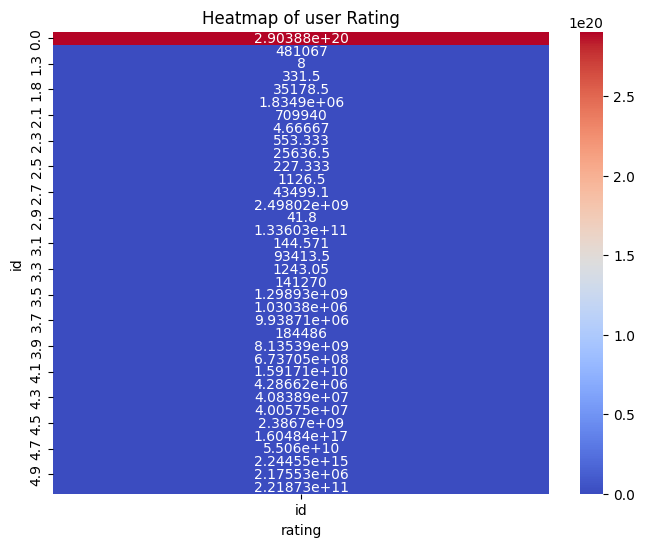

In [21]:
plt.figure(figsize = (8 , 6))
sns.heatmap(heap_map_data , annot=True , fmt="g" , cmap="coolwarm" , cbar=True)
plt.title("Heatmap of user Rating")
plt.xlabel("rating")
plt.ylabel("id")
plt.show()

Text(0.5, 1.0, 'Most Popular Items')

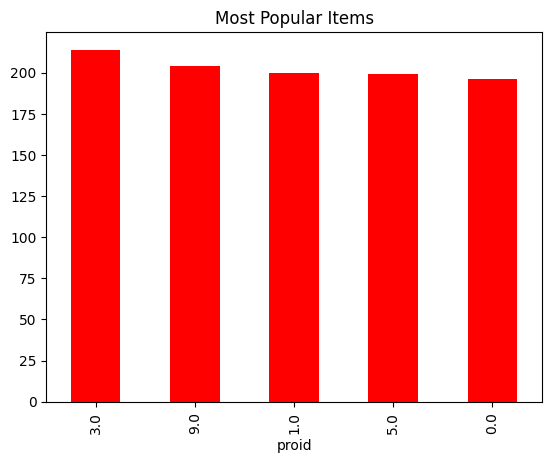

In [22]:
popular_item = train_data['proid'].value_counts().head(5)
popular_item.plot(kind='bar' , color="red")
plt.title("Most Popular Items")

<Axes: xlabel='rating'>

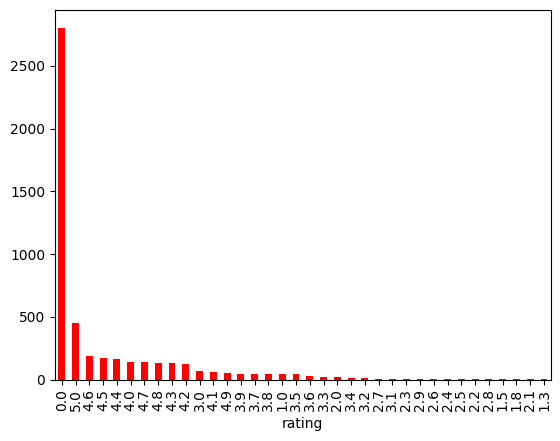

In [23]:
train_data["rating"].value_counts().plot(kind="bar" , color="red")

data cleaning


In [24]:
# scipy nlp library to remove stop words

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")   # english model

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS ]
    return ",".join(tags)

columns_to_extract_tags_from = ['category' , 'brand' , 'description']


for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [28]:
train_data

,id,proid,rating,reviews count,category,brand,name,imgurl,description,tags
0,1.705737e+09,2.0,0.0,0.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,"beauty,hair,care,hair,color,auburn,hair,color",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty,hair,care,hair,color,permanent,hair,color",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,"beauty,makeup,lip","kokie,cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal,stock,essentials,personal,care,stock,...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...,...,...,...,...,...,...,...,...,...
4995,2.771000e+03,208.0,4.5,2.0,"household,essentials,air,fresheners,spray,air,...","eclectic,lady","Garden Mint Room Spray (Double Strength), 4 ou...",https://i5.walmartimages.com/asr/0e0416ae-6b70...,"Garden Mint is a lovely blend of spearmint, le...","Garden Mint Room Spray (Double Strength), 4 ou..."
4996,0.000000e+00,1.0,3.9,7484.0,"beauty,hair,care,hair,color,permanent,hair,color",garnier,Garnier Nutrisse Nourishing Hair Color Creme (...,https://i5.walmartimages.com/asr/24d7a837-51f8...,Garnier Nutrisse Nourishing Hair Color Creme B...,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,3.400000e+01,96.0,0.0,4.0,"beauty,makeup,nails",stoneway,"Nail File Electric Drill, 6 in 1 Professional ...",https://i5.walmartimages.com/asr/d6202179-2c93...,Multifunctional : Our nail drill kit come with...,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,9.000000e+00,7.0,0.0,0.0,"premium,beauty,premium,bath,body,premium,body,...",creed,Creed Love In Black Hair And Body Wash 6.8oz/2...,https://i5.walmartimages.com/asr/3dc99239-66d2...,,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [25]:
train_data["tags"] = train_data[columns_to_extract_tags_from].apply(lambda row: ",".join(row) , axis=1)

<h1>rating base recommedation system</h1>

In [26]:
train_data.head(2)

,id,proid,rating,reviews count,category,brand,name,imgurl,description,tags
0,1.705737e+09,2.0,0.0,0.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium,beauty,premium,makeup,premium,nail,pol..."
1,9.500000e+01,76.0,0.0,0.0,"beauty,hair,care,hair,color,auburn,hair,color",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack,3,pack,3,upc,381519000201,beautiful,natur...","beauty,hair,care,hair,color,auburn,hair,color,..."


In [27]:
# to crete new data koown as average data

average_data = train_data.groupby(['name' , 'reviews count' , 'brand' , 'imgurl'])['rating'].mean().reset_index()

average_data

,name,reviews count,brand,imgurl,rating
0,$6 Mail-In Rebate Available Braun Epilator Sil...,146.0,braun,https://i5.walmartimages.com/asr/c7d78838-e8e2...,4.5
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter,thomas,roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
2,($11 Value) Love Beauty and Planet Coconut Wat...,278.0,"love,beauty,planet",https://i5.walmartimages.com/asr/0348d82d-2a13...,0.0
3,($125 Value) Impressions Vanity Touch Pro LED ...,2.0,"impressions,vanity",https://i5.walmartimages.com/asr/b886b154-97fd...,2.5
4,($129 Value) CHI G2 Ceramic Titanium Infused H...,23.0,chi,https://i5.walmartimages.com/asr/9bcc0ed7-d62c...,4.4
...,...,...,...,...,...
4987,"wet n wild Photo Focus Correcting Palette, Col...",12.0,"wet,n,wild",https://i5.walmartimages.com/asr/750275fb-ccfa...,3.3
4988,"wet n wild Photo Focus Liquid Foundation, Medi...",7827.0,"wet,n,wild",https://i5.walmartimages.com/asr/c2c5dc7e-9bbb...,0.0
4989,"wet n wild Photo Focus Pressed Powder, Dark Café",635.0,"wet,n,wild",https://i5.walmartimages.com/asr/57bd497f-0d5c...,4.2
4990,"wet n wild Silk Finish Lipstick, Honolulu Is C...",4259.0,"wet,n,wild",https://i5.walmartimages.com/asr/0e25f705-a924...,3.9


In [28]:
# for sorting the rating of products

top_rated_products = average_data.sort_values(by='rating' , ascending=False)


In [29]:
top_rated_products = average_data.sort_values(by='rating' , ascending=False)
rating_base_recommendation = top_rated_products.head(10)
rating_base_recommendation

,name,reviews count,brand,imgurl,rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4.0,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5.0
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2.0,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5.0
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2.0,"gold,bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5.0
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24.0,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5.0
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2.0,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5.0
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1.0,"red,devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5.0
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1.0,"air,wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5.0
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4.0,"bain,de,terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5.0
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12.0,"long,aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5.0
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1.0,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5.0


C:\Users\saadu\AppData\Local\Temp\ipykernel_15272\3701998394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation["rating"] = rating_base_recommendation["rating"].astype(int)
C:\Users\saadu\AppData\Local\Temp\ipykernel_15272\3701998394.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation["reviews count"] = rating_base_recommendation["reviews count"].astype(int)


In [ ]:
# convert into intergrs

rating_base_recommendation["rating"] = rating_base_recommendation["rating"].astype(int)
rating_base_recommendation["reviews count"] = rating_base_recommendation["reviews count"].astype(int)

In [31]:
# convert into intergrs
rating_base_recommendation

,name,reviews count,brand,imgurl,rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2,"gold,bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1,"red,devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1,"air,wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4,"bain,de,terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12,"long,aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5


<h1>Content Based Recommendation</h1>

In [32]:
train_data.head(1)

,id,proid,rating,reviews count,category,brand,name,imgurl,description,tags
0,1.705737e+09,2.0,0.0,0.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium,beauty,premium,makeup,premium,nail,pol..."


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data["tags"])
cosine_simi_content = cosine_similarity(tfidf_matrix_content , tfidf_matrix_content)

In [34]:
# thsi is the comparison of tags by using cosine similarity 
cosine_simi_content

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

In [35]:
train_data["name"][0]

'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

In [36]:
# compare that text with our data
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data["name"] == item_name].index[0]

In [37]:
simiar_items = list(enumerate(cosine_simi_content[item_index]))


In [48]:
simiar_items

[(0, np.float64(1.0)),
 (1, np.float64(0.003293490176511423)),
 (2, np.float64(0.0034267839446364408)),
 (3, np.float64(0.012495180680392539)),
 (4, np.float64(0.0010137786111337028)),
 (5, np.float64(0.006509251840999331)),
 (6, np.float64(0.007298885191046501)),
 (7, np.float64(0.051521278529606127)),
 (8, np.float64(0.010737263631647863)),
 (9, np.float64(0.0031426051993414116)),
 (10, np.float64(0.0)),
 (11, np.float64(0.15887045344135584)),
 (12, np.float64(0.04099172829580452)),
 (13, np.float64(0.003026991257394802)),
 (14, np.float64(0.0)),
 (15, np.float64(0.005703429632048307)),
 (16, np.float64(0.3398459006724781)),
 (17, np.float64(0.0)),
 (18, np.float64(0.0045137099938964784)),
 (19, np.float64(0.0038781115309253736)),
 (20, np.float64(0.008744672609045281)),
 (21, np.float64(0.0)),
 (22, np.float64(0.009447950762280301)),
 (23, np.float64(0.0)),
 (24, np.float64(0.005083342905504128)),
 (25, np.float64(0.0)),
 (26, np.float64(0.007177532966623009)),
 (27, np.float64(0.00

In [38]:
similar_items = sorted(simiar_items , key=lambda x:x[1] , reverse=True)
top_similar_items = similar_items[1:10]
top_similar_items

recommended_item_index = [x[0] for x in top_similar_items]

In [39]:
top_similar_items



[(156, np.float64(1.0)),
 (184, np.float64(1.0)),
 (205, np.float64(1.0)),
 (237, np.float64(1.0)),
 (325, np.float64(1.0)),
 (375, np.float64(1.0)),
 (402, np.float64(1.0)),
 (706, np.float64(1.0)),
 (886, np.float64(1.0))]

In [40]:
train_data.iloc[recommended_item_index]["name"]

156    OPI Nail Lacquer Polish .5oz/15mL - This Gown ...
184    OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...
205    OPI Nail Lacquer - Dont Bossa Nova Me Around -...
237    OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...
325    OPI Gel Polish Fall 2019 Scotland Collection G...
375    OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...
402     OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz
706    OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...
886    OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...
Name: name, dtype: object

In [41]:
train_data.iloc[recommended_item_index][["name" , "reviews count" , "brand"]]

,name,reviews count,brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['name', 'reviews count', 'brand', 'imgurl', 'rating']]

    return recommended_items_details

In [43]:
print(train_data.columns)


Index(['id', 'proid', 'rating', 'reviews count', 'category', 'brand', 'name',
       'imgurl', 'description', 'tags'],
      dtype='object')


In [44]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,name,reviews count,brand,imgurl,rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [45]:
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,name,reviews count,brand,imgurl,rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city,color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0


user item similarity collaborative filtering 

In [46]:
user_item_matrix = train_data.pivot_table(index='id', columns='proid', values='rating',aggfunc='mean').fillna(0).astype(int)


In [47]:
user_similarity = cosine_similarity(user_item_matrix)


In [48]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [49]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [50]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)
    
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['proid'].isin(recommend_items)][['name','reviews count','brand','imgurl','rating']]


In [51]:
recommended_items_details.head(10)

,name,reviews count,brand,imgurl,rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design,essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
78,"Paul Sebastian Fine Cologne Spray, Cologne for...",28.0,"paul,sebastian",https://i5.walmartimages.com/asr/03d08a07-18d7...,4.8
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
92,"Bytewise Organic Moringa Leaf Powder, 12 Oz",0.0,bytewise,https://i5.walmartimages.com/asr/076f2b3f-fdc3...,0.0
94,Ag Hair Cosmetics Ultradynamics Extra-Firm Fin...,0.0,"ag,hair",https://i5.walmartimages.com/asr/5d217d98-a385...,0.0
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0


In [52]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='id', columns='proid', values='rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['proid'].isin(recommended_items)][['name', 'reviews count', 'brand', 'imgurl', 'rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,name,reviews count,brand,imgurl,rating
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
85,"BioAstin Hawaiian Astaxanthin, Vegan, 12mg, 75 Ct",3.0,bioastin,https://i5.walmartimages.com/asr/6da9e238-b19e...,5.0
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.1
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.0
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,0.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,0.0
155,"Crest 3D White Brilliance Mouthwash, Alcohol F...",63.0,crest,https://i5.walmartimages.com/asr/1fcc5525-9ae3...,0.0
174,COVERGIRL Outlast All-Day Moisturizing Lip Col...,36.0,covergirl,https://i5.walmartimages.com/asr/4479896f-c6c4...,0.0
193,"Revlon ColorStay Skinny Liquid Liner, 304 Gree...",70.0,revlon,https://i5.walmartimages.com/asr/aa3b20a6-3d6d...,4.5
212,"Comvita Certified UMF 20+ Manuka Honey, Raw & ...",0.0,comvita,https://i5.walmartimages.com/asr/3cdc1498-a2ac...,0.0
241,"Ahava Mens Mineral Hand Cream, 3.4 Oz",0.0,ahava,https://i5.walmartimages.com/asr/f74e4bb7-47d3...,0.0


<h1>hybrid recommendation</h1>

In [53]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()
    
    return hybrid_rec.head(10)
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,name,reviews count,brand,imgurl,rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [54]:
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,name,reviews count,brand,imgurl,rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black,radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.7
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black,radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.3
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.8
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.1
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,0.0,"black,opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,0.0
